In [35]:
from importlib import reload
import pandas as pd
import xdem
import xsnow
from xsnow.godh import load_gdf,best_shift_px,get_dh_by_shift_px_gdf,load_gdf
from xsnow.misc import df_sampling_from_dem

In [34]:
reload(xsnow.misc)
reload(xsnow.godh)
reload(xdem)
reload(xdem.coreg)
from importlib import reload
import xsnow
import xsnow.godh

## DEM Coreg is a bound-restricted minimizing problem.


- DEM Coreg is a bound-restricted minimizing problem, but suffering from noise.


In [3]:
# Loading the dataset.

# 1 ICESat-2 snow free measurements.
sf_gdf = pd.read_csv('snow_free_land_gdf_normal_qc.csv', sep='\t', encoding='utf-8')

# 2 DTM 10 exmaple (10 m Norway DTM-10)
#fid_dtm10 = r'\\hypatia.uio.no\lh-mn-geofag-felles\projects\snowdepth\zhihaol\data\dtm10_finse_merged.tif'
fid_dtm10 = r'\\hypatia.uio.no\lh-mn-geofag-felles\projects\snowdepth\data\DEM\Norway\DTM10_UTM33\6702_4_10m_z33.tif'

dtm_10_ = xdem.DEM(fid_dtm10)
dtm_10 = dtm_10_ + xdem.DEM('no_kv_HREF2018B_NN2000_EUREF89.tif').reproject(dtm_10_,resampling='bilinear')

# 3 DTM 1 exmaple (1 m Norway DTM-1)
fid_dtm1 = r'\\hypatia.uio.no\lh-mn-geofag-felles\projects\snowdepth\data\DEM\Norway\DTM1_UTM33\DTM1_11-11_UTM33\33-113-119.tif'
dtm_1_ = xdem.DEM(fid_dtm1)
dtm_1 = dtm_1_ + xdem.DEM('no_kv_HREF2018B_NN2000_EUREF89.tif').reproject(dtm_1_,resampling='bilinear')

# subset snow free measurements
from xsnow.godh import load_gdf
sf_subset_dtm10_ = load_gdf(sf_gdf,dtm_10,z_name='h_te_best_fit')
sf_subset_dtm1_ = load_gdf(sf_gdf,dtm_1,z_name='h_te_best_fit')

print(f'The length of sf_subset_dtm10: {len(sf_subset_dtm10_)} points')
print(f'The length of sf_subset_dtm1: {len(sf_subset_dtm1_)} points')

The length of sf_subset_dtm10: 44149 points
The length of sf_subset_dtm1: 1586 points


In [39]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import xdem
from xsnow.misc import df_sampling_from_dem

def yield_surface_noise(dtm_10,sf_gdf_subset,
                        bond,perc_t=100,std_t=3,stat='nmad', number_corg=None, downsampling_list=None,z_name='h_te_best_fit',
                        nuthkaab=1,gdc_qc=1,weight=None):
    
    if number_corg is None:
        number_corg = 1
        
    if downsampling_list:
        for sampling in downsampling_list:
            res = [best_shift_px(dtm_10, sf_gdf_subset, disp=False,stat=stat,perc_t=perc_t,std_t=std_t, downsampling=sampling,z_name=z_name,weight=weight) for _ in range(number_corg)]
            nmad,rmse,std,median = surface_noise(dtm_10,sf_gdf_subset,bond,perc_t=perc_t,std_t=std_t,downsampling=sampling,z_name=z_name)
            
            if nuthkaab == 1:
                try:
                    func = xdem.coreg.NuthKaab()
                    func.fit_pts(sf_gdf_subset.sample(frac=sampling/len(sf_gdf_subset),random_state=42),dtm_10,mask_highcurv=False)
                    res_nk = (func._meta["offset_east_px"],func._meta["offset_north_px"],func._meta["bias"],func._meta["nmad"])
                    print(f'NuthKaab coreg on {sampling}: {res_nk}')
                except ValueError:
                    res_nk = None
            else:
                res_nk = None

            if gdc_qc == 1:
                sf_subset_dtm10_ref = sf_gdf_subset.query('subset_te_flag == 5')
                res_qc = best_shift_px(dtm_10, sf_subset_dtm10_ref, disp=False,stat=stat,perc_t=perc_t,std_t=std_t, downsampling=sampling,z_name=z_name)
            else:
                res_qc = None

            yield nmad, rmse, std, median,res,res_nk,res_qc,min(sampling,len(sf_gdf_subset))

def surface_noise(dtm_10,sf_gdf_subset,bond,perc_t=100,std_t=None,downsampling=False,z_name='h_te_best_fit'):

    if isinstance(sf_gdf_subset,xdem.DEM):
        sf_gdf_subset = df_sampling_from_dem(dtm_10,sf_gdf_subset,samples=10000)

    if downsampling and len(sf_gdf_subset) > downsampling:
        sf_gdf_subset = sf_gdf_subset.sample(frac=downsampling/len(sf_gdf_subset),random_state=42).copy()
        print('Running on downsampling. The length of the gdf:',len(sf_gdf_subset))
        print('Set downsampling = other value or False to make a change.')

    bond_ = np.arange(bond[0],bond[1],bond[2])
    nmad = np.zeros((len(bond_),len(bond_)))
    rmse = np.zeros((len(bond_),len(bond_)))
    std = np.zeros((len(bond_),len(bond_)))
    median = np.zeros((len(bond_),len(bond_)))

    for e,n in product(bond_,bond_):
        results = get_dh_by_shift_px_gdf(dtm_10,sf_gdf_subset,(e,n),0,stat='all',perc_t=perc_t,std_t=std_t,z_name=z_name)
        row = int((n-bond[0])/bond[2])
        col = int((e-bond[0])/bond[2])
        nmad[row,col] = results['nmad']
        rmse[row,col] = results['rmse']
        std[row,col] = results['std']
        median[row,col] = results['median']

    return nmad,rmse,std,median

def surface_plot(Z,bond,xlim=None,ylim=None,zlim=(0,2),
                 ax=None,title=None,
                 res=None,res_1=None,res_2=None,res_3=None, minimal=False,zlabel='[m]',
                 z_step_level=None,zlim_s=20):

    if ax is None:
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    if xlim is None:
        xlim=bond[:2]
    if ylim is None:
        ylim=bond[:2]

    # Make a grid.
    X = Y = np.arange(bond[0],bond[1],bond[2])
    X, Y = np.meshgrid(X, Y)

    # plot minimal
    zmin = np.min(Z)
    zmax = np.max(Z)
    mask = np.array(Z) == zmin
    #color = np.where(mask,'blue','red')
    
    # Plot the 3D surface
    ax.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                    alpha=0.3)

    # Plot projections of the contours for each dimension.  By choosing offsets
    # that match the appropriate axes limits, the projected contours will sit on
    # the 'walls' of the graph.
    kwargs = {}
    if z_step_level:
        kwargs['levels'] = np.arange(zmin, zmax + z_step_level, z_step_level)
    else:
        z_step_level = zlim[1] / zlim_s
        kwargs['levels'] = np.arange(zmin, zmax + z_step_level, z_step_level)


    z_contour = ax.contour(X, Y, Z,zdir='z', offset=zlim[0], cmap='coolwarm',**kwargs)
    ax.contour(X, Y, Z, zdir='x', offset=xlim[0], cmap='coolwarm')
    ax.contour(X, Y, Z, zdir='y', offset=ylim[1], cmap='coolwarm_r')
    
    #ax.clabel(z_contour, kwargs['levels'][0::2], z_contour.levels[::2], inline=True,fmt ='%1.1f', colors='black', fontsize='x-large')

    if minimal:
        # scatter minimal on bottom
        ax.scatter(X[mask], Y[mask], zlim[0], color='blue',label='minimal')
        #scatter minimal on z-axis
        ax.scatter(xlim[1], ylim[1], zmin,marker="x",color='blue')
    
    # plot gradient results
    if res:

        # plot [0,0] on bottom
        ax.scatter(0, 0, zlim[0],alpha=0.4, color='black',edgecolors='white',label='(0,0)')

        # plot [shift matrix] by gradient descending on bottom
        _x,_y = np.array(res)[:,0],np.array(res)[:,1]
        _nmad,_rmse,_std = np.array(res)[:,3],np.array(res)[:,4],np.array(res)[:,5]
        ax.scatter(_x, _y, zlim[0],alpha=0.5, s=7,color='green',label='GDC')

        # plot shift matrix on z axis
        if zlabel == 'NMAD [m]':
            _z = _nmad
        if zlabel == 'RMSE [m]':
            _z = _rmse
        if zlabel == 'STD [m]':
            _z = _std
        
        #ax.scatter([xlim[1]]*len(_x), [ylim[1]]*len(_y),_z, marker="x", color='green')
    
    # plot nuthkaab results
    if res_1:
        # plot [shift matrix] by gradient descending on bottom
        ax.scatter(res_1[0], res_1[1], zlim[0],alpha=0.5, s=10,color='red',label='NuthKaab')

    # plot reference results
    if res_2:
        # plot [shift matrix] by gradient descending on bottom
        ax.scatter(res_2[0], res_2[1], zlim[0],alpha=1, s=10,color='purple',label='GDC_qc')

    if res_3:
        # plot [shift matrix] by gradient descending on bottom
        ax.scatter(res_2[0], res_2[1], zlim[0],alpha=1, s=10,color='black',label='others')

    ax.set(xlim=xlim, ylim=ylim, zlim=zlim,
        xlabel='Shifted E [px]', ylabel='Shifted N [px]', zlabel=zlabel,title=title)

    ax.legend()


## Case 1 - Shifted DEM

Nuth & Kaab (2011) showed elevation difference in a 2D scheme with $\alpha$ as the magnitude of the horizontal shift, b as the direction of the shift, which is extremely useful for coregistration when there are enough points and the size and resolution of DEM are relatively manageable.

![](https://i.imgur.com/UzkOHot.png)

We can also plot the variation of elevation difference in a 3D scheme. In this case, I shifted a DTM10 (1.2, -0.7) px horizontaly and 0.16 m vertically on purpose and co-register it back in a brute test.


- Brute test calculated the elevation difference in 0.1 px interval over a window (-2 px, 2 px) on east and north. 
- All coregs are shifted base on NMAD.
- The points are subsampled to 10000, 3000, 1000.



In [37]:
from xsnow.misc import dem_shift

# Shift a DTM10 (1.2,-0.7) px and 0.16 m on purpose
dtm_10_shifted = dem_shift(dtm_10,1.2,-0.7,0.16)
dem_tba = dtm_10_shifted
df_ref = df_sampling_from_dem(dtm_10,dem_tba,samples=20000)

Running best_shift_px on downsampling. The length of the gdf: 10000
Gradient Descending Coreg fit matrix(e_px,n_px,bias),nmad:(-1.2031,0.7031,-0.1630),0.1780
Running on downsampling. The length of the gdf: 10000
Set downsampling = other value or False to make a change.
NuthKaab coreg on 10000: (-1.2059757056614222, 0.6973771900864857, -0.16427612, 0.17899064941406248)


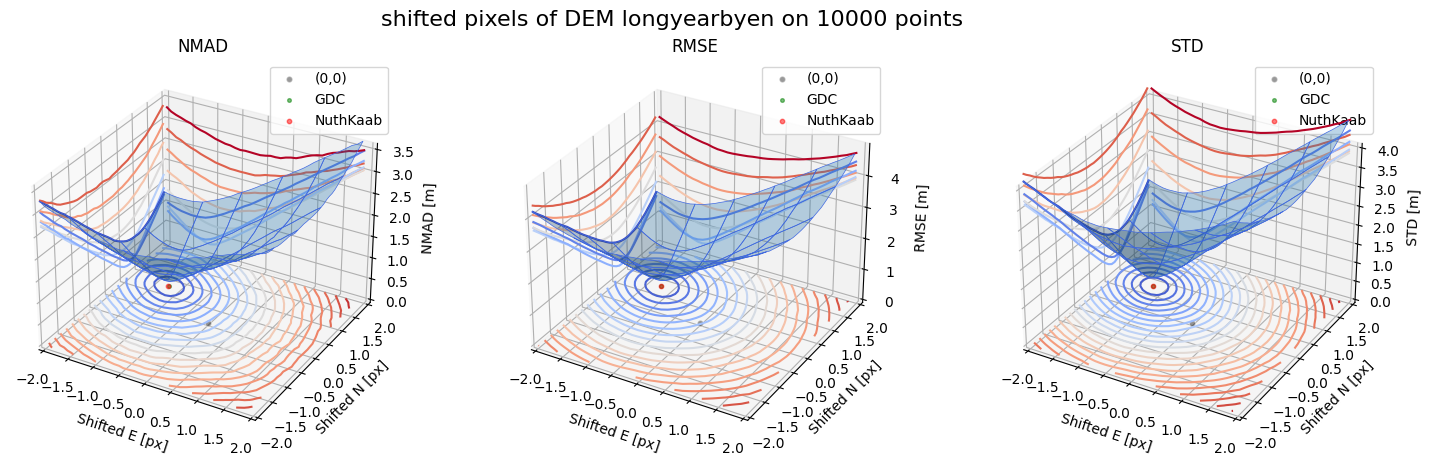

Running best_shift_px on downsampling. The length of the gdf: 3000
Gradient Descending Coreg fit matrix(e_px,n_px,bias),nmad:(-1.2031,0.7031,-0.1630),0.1780
Running on downsampling. The length of the gdf: 3000
Set downsampling = other value or False to make a change.
NuthKaab coreg on 3000: (-1.199313462032361, 0.6898301972399311, -0.16362, 0.1797598205566406)


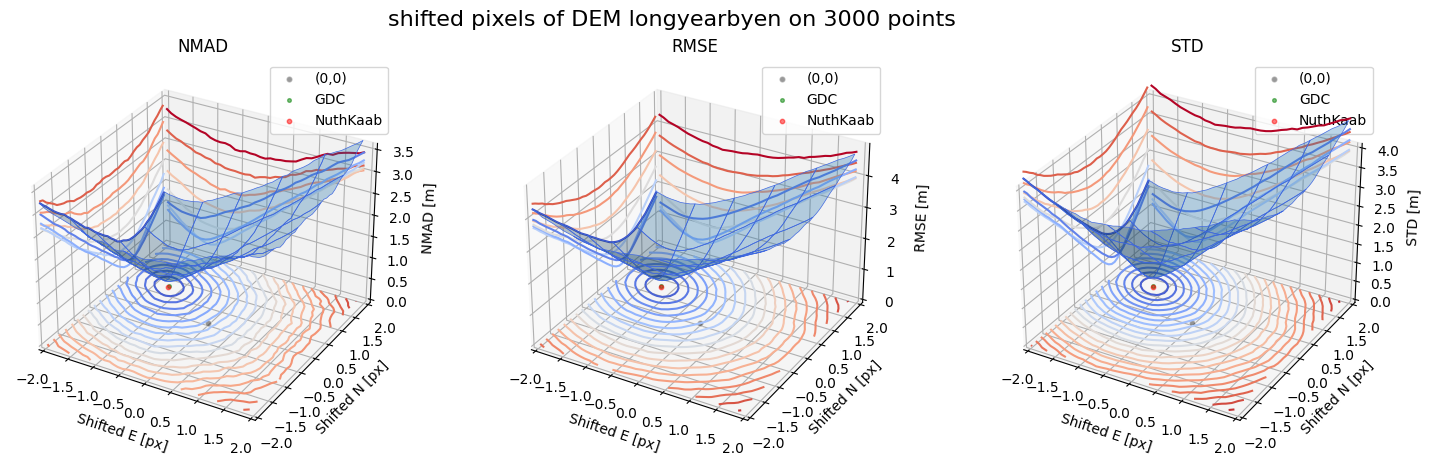

Running best_shift_px on downsampling. The length of the gdf: 1000
Gradient Descending Coreg fit matrix(e_px,n_px,bias),nmad:(-1.1815,0.6815,-0.1622),0.1794
Running on downsampling. The length of the gdf: 1000
Set downsampling = other value or False to make a change.


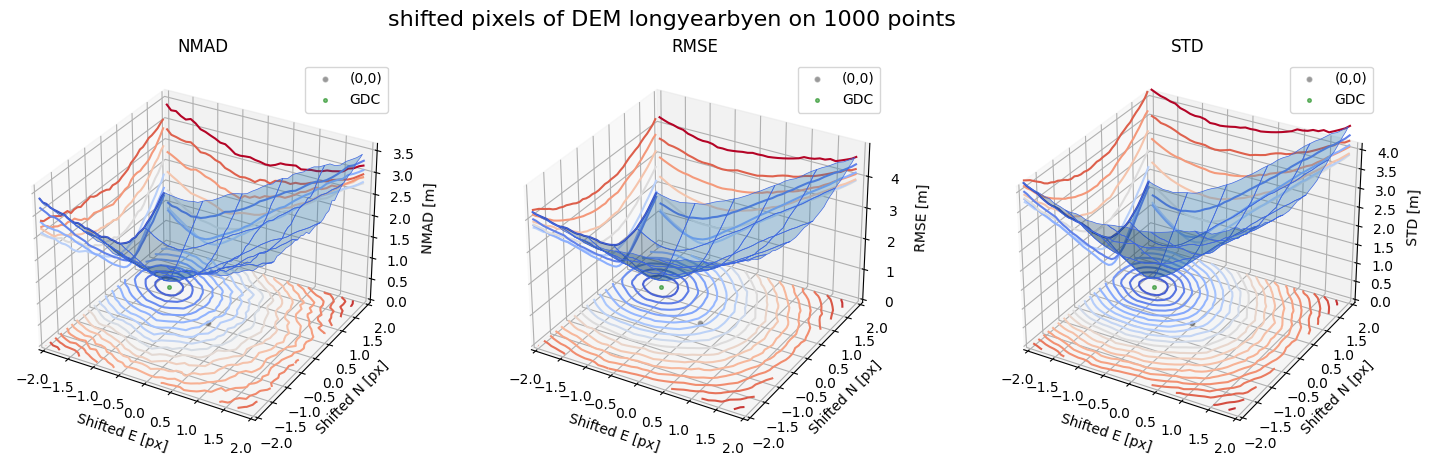

In [40]:

bond = (-2,2,0.1)
xlim=(-2,2)
ylim=(-2,2)

for nmad, rmse, std, median,res,res_nk,res_qc,sampling in yield_surface_noise(dem_tba,df_ref,bond=bond,perc_t=100,std_t=3,downsampling_list=[10000,3000,1000],gdc_qc=0,z_name='z'):
    z_lim_nmad = (max(0,res[0][3]-1),res[0][3]*20)
    z_lim_rmse = (max(0,res[0][4]-1.5),res[0][4]*20-1)
    z_lim_std = (max(0,res[0][5]-1.5),res[0][5]*20-1)

    fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18, 5),subplot_kw={"projection": "3d"})
    fig.suptitle(f'shifted pixels of DEM longyearbyen on {sampling} points', fontsize=16)
    surface_plot(nmad, bond=bond,xlim=xlim,ylim=ylim,ax=ax1,title='NMAD', res=res,res_1=res_nk, res_2=res_qc, zlabel='NMAD [m]',zlim=z_lim_nmad,zlim_s=20)
    surface_plot(rmse,bond=bond,xlim=xlim,ylim=ylim,ax=ax2,title='RMSE',res=res,res_1=res_nk,res_2=res_qc, zlabel='RMSE [m]',zlim=z_lim_rmse,zlim_s=20)
    surface_plot(std,bond=bond,xlim=xlim,ylim=ylim,ax=ax3,title='STD',res=res,res_1=res_nk,res_2=res_qc, zlabel='STD [m]',zlim=z_lim_std,zlim_s=20)
    plt.show()

## Case 2 - DEM Longyearbyen 1990 and Longyearbyen 2009

In [41]:
from xsnow.misc import df_sampling_from_dem
from xdem import examples
from geoutils import Vector,Raster

dem_ref = xdem.DEM(examples.get_path("longyearbyen_ref_dem"))
dem_tba = xdem.DEM(examples.get_path("longyearbyen_tba_dem"))
glacier_mask = Vector(examples.get_path("longyearbyen_glacier_outlines"))
inlier_mask = ~glacier_mask.create_mask(dem_ref)

df_ref = df_sampling_from_dem(dem_ref,dem_tba,inlier_mask=inlier_mask,samples=15000, offset='ul')

Running best_shift_px on downsampling. The length of the gdf: 10000
Gradient Descending Coreg fit matrix(e_px,n_px,bias),nmad:(-0.5469,-0.1250,-1.8884),2.4996
Running on downsampling. The length of the gdf: 10000
Set downsampling = other value or False to make a change.
NuthKaab coreg on 10000: (-0.44989970346639757, -0.13631736964576785, -1.9579468, 2.543117335510254)


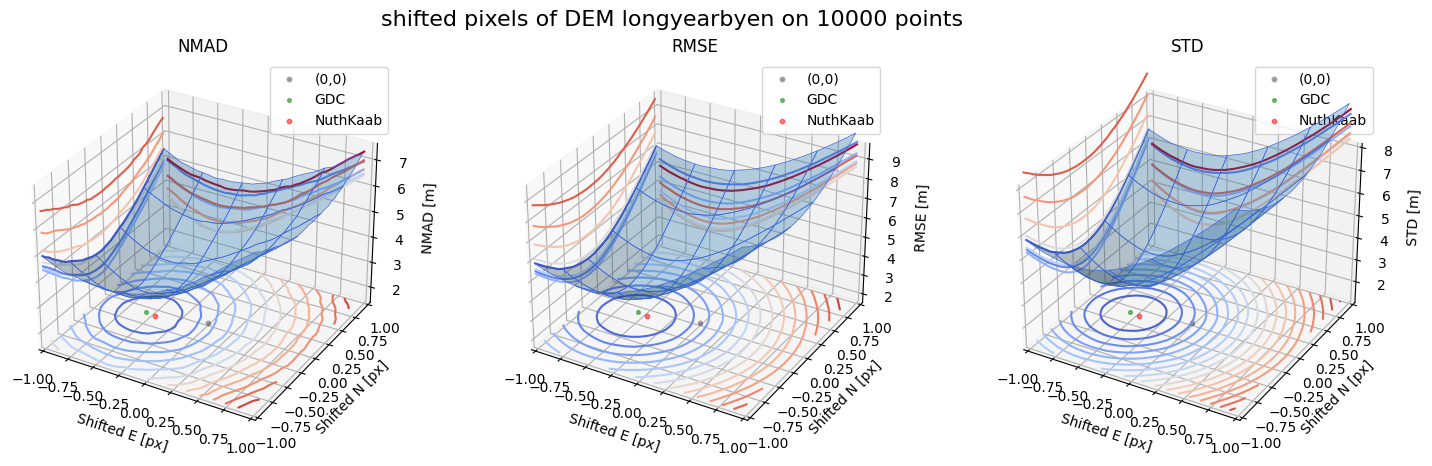

Running best_shift_px on downsampling. The length of the gdf: 3000
Gradient Descending Coreg fit matrix(e_px,n_px,bias),nmad:(-0.5000,-0.1562,-1.8764),2.5242
Running on downsampling. The length of the gdf: 3000
Set downsampling = other value or False to make a change.
NuthKaab coreg on 3000: (-0.43152742135357697, -0.17112353846215173, -1.9326782, 2.547257286071777)


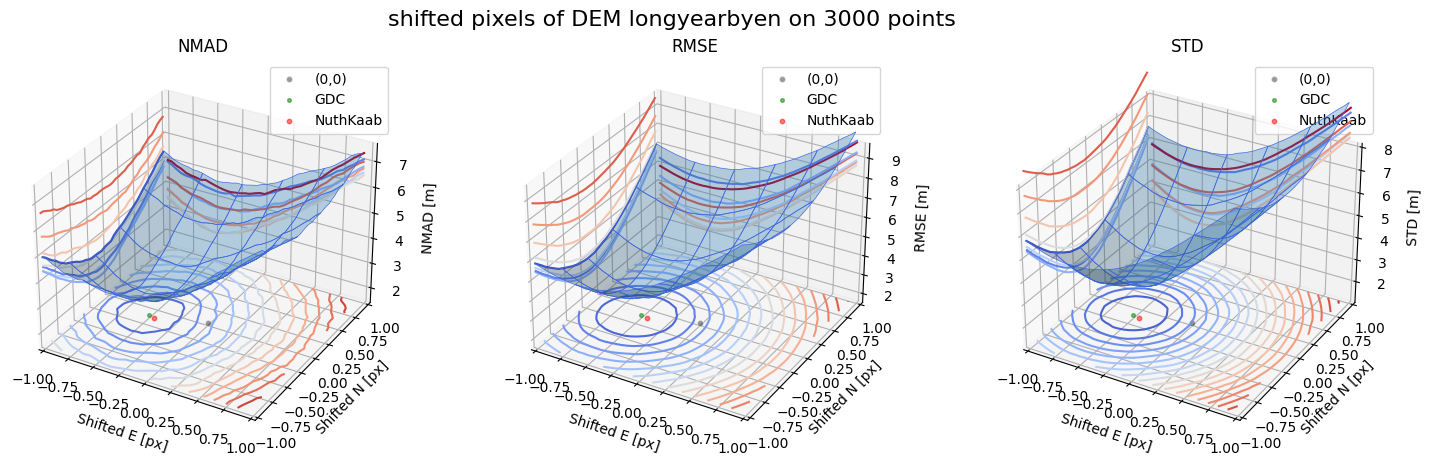

Running best_shift_px on downsampling. The length of the gdf: 1000
Gradient Descending Coreg fit matrix(e_px,n_px,bias),nmad:(-0.5000,-0.1250,-1.8980),2.5237
Running on downsampling. The length of the gdf: 1000
Set downsampling = other value or False to make a change.


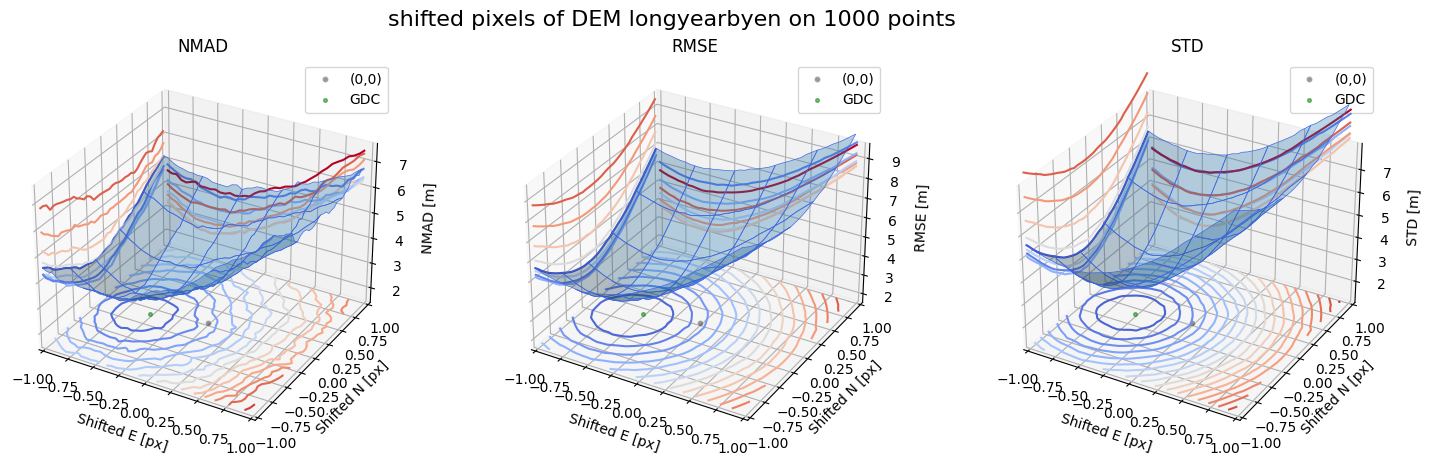

In [42]:
bond = (-1,1,0.05)

# axes limit
xlim=(-1,1)
ylim=(-1,1)

for nmad, rmse, std, median,res,res_nk,res_qc,sampling in yield_surface_noise(dem_tba, df_ref,bond=bond,perc_t=100,std_t=3,downsampling_list=[10000,3000,1000],gdc_qc=0,z_name='z'):
    z_lim_nmad = (max(0,res[0][3]-1),res[0][3]*3)
    z_lim_rmse = (max(0,res[0][4]-1.5),res[0][4]*3)
    z_lim_std = (max(0,res[0][5]-1.5),res[0][5]*3)

    fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18, 5),subplot_kw={"projection": "3d"})
    fig.suptitle(f'shifted pixels of DEM longyearbyen on {sampling} points', fontsize=16)
    surface_plot(nmad, bond=bond,xlim=xlim,ylim=ylim,ax=ax1,title='NMAD', res=res,res_1=res_nk, res_2=res_qc, zlabel='NMAD [m]',zlim=z_lim_nmad,zlim_s=20)
    surface_plot(rmse,bond=bond,xlim=xlim,ylim=ylim,ax=ax2,title='RMSE',res=res,res_1=res_nk,res_2=res_qc, zlabel='RMSE [m]',zlim=z_lim_rmse,zlim_s=20)
    surface_plot(std,bond=bond,xlim=xlim,ylim=ylim,ax=ax3,title='STD',res=res,res_1=res_nk,res_2=res_qc, zlabel='STD [m]',zlim=z_lim_std,zlim_s=20)
    plt.show()

## DTM10

In [43]:
sf_subset_dtm10 = sf_subset_dtm10_
#sf_subset_dtm10 = sf_subset_dtm10_.query('subset_te_flag == 5')


Running best_shift_px on downsampling. The length of the gdf: 10000
Gradient Descending Coreg fit matrix(e_px,n_px,bias),nmad:(-0.4375,0.2656,-0.0065),0.5992
Running on downsampling. The length of the gdf: 10000
Set downsampling = other value or False to make a change.
NuthKaab coreg on 10000: (-0.43959885000839216, 0.2685718552192047, -0.0128173828125, 0.5952479736328125)
Running best_shift_px on downsampling. The length of the gdf: 10000
Gradient Descending Coreg fit matrix(e_px,n_px,bias),nmad:(-0.4844,0.3125,0.1088),0.3848


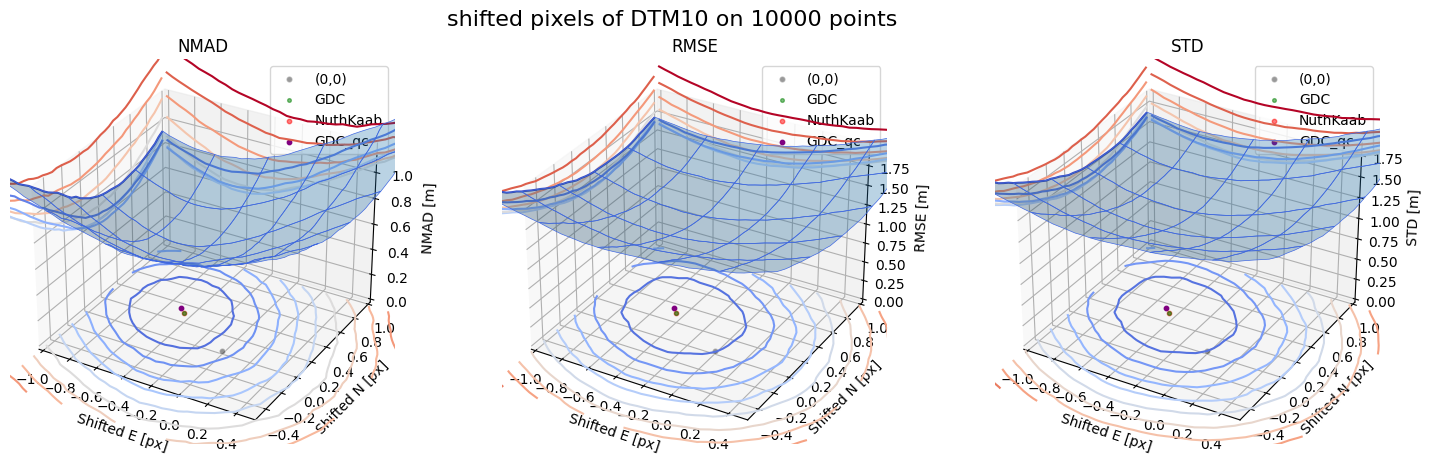

Running best_shift_px on downsampling. The length of the gdf: 3000
Gradient Descending Coreg fit matrix(e_px,n_px,bias),nmad:(-0.4844,0.1815,-0.0063),0.6086
Running on downsampling. The length of the gdf: 3000
Set downsampling = other value or False to make a change.
NuthKaab coreg on 3000: (-0.4273086350909474, 0.259520889514669, -0.01318359375, 0.5863798828125)
Running best_shift_px on downsampling. The length of the gdf: 3000
Gradient Descending Coreg fit matrix(e_px,n_px,bias),nmad:(-0.4591,0.2909,0.1092),0.3856


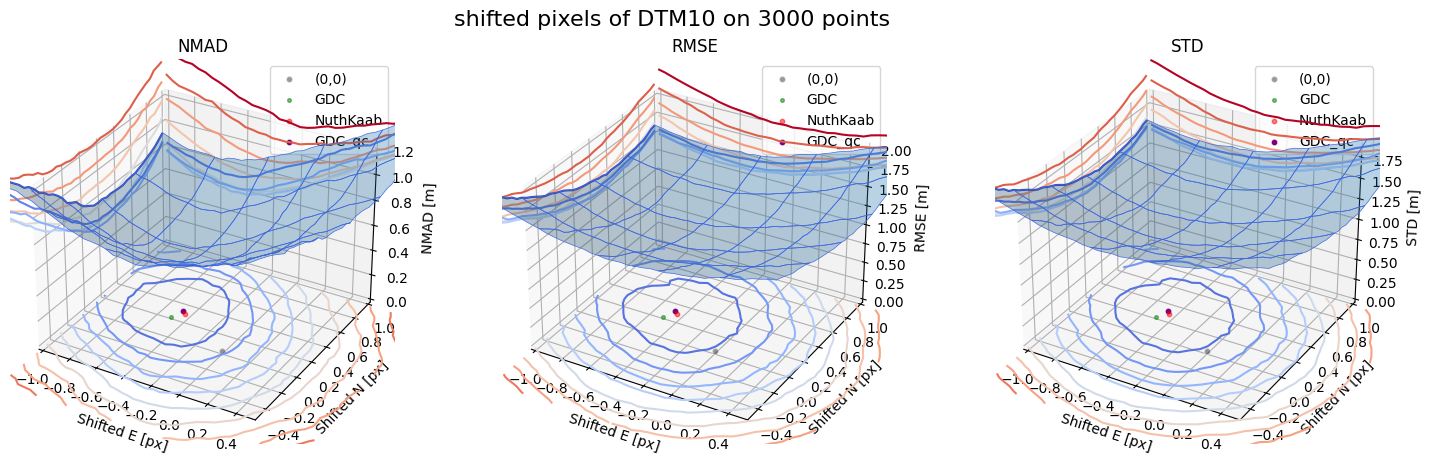

Running best_shift_px on downsampling. The length of the gdf: 1000
Gradient Descending Coreg fit matrix(e_px,n_px,bias),nmad:(-0.4688,0.5060,-0.0110),0.6305
Running on downsampling. The length of the gdf: 1000
Set downsampling = other value or False to make a change.
Running best_shift_px on downsampling. The length of the gdf: 1000
Gradient Descending Coreg fit matrix(e_px,n_px,bias),nmad:(-0.4627,0.3438,0.1067),0.3884


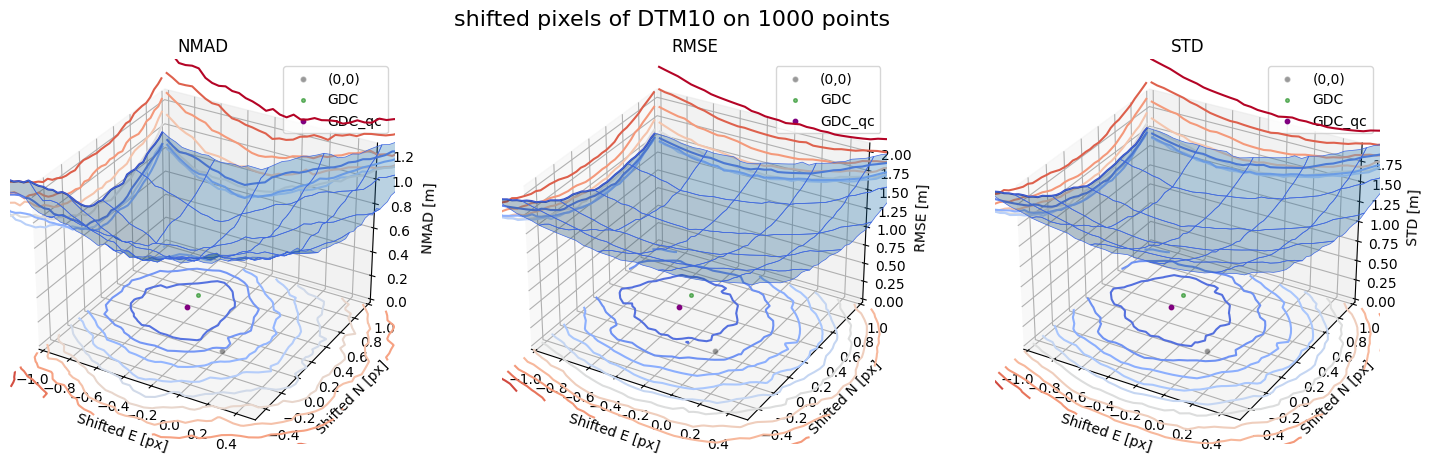

In [44]:
bond = (-1.0,1.0,0.05)

# axes limit
xlim=(-1.0,0.5)
ylim=(-0.5,1.0)

for nmad, rmse, std, median,res,res_nk,res_qc,sampling in yield_surface_noise(dtm_10,sf_subset_dtm10,bond=bond,perc_t=100,std_t=3,downsampling_list=[10000,3000,1000],weight='subset_te_flag'):
    z_lim_nmad = (0,res[0][3]*2)
    z_lim_rmse = (0,res[0][4]*2-1)
    z_lim_std = (0,res[0][5]*2-1)  

    fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18, 5),subplot_kw={"projection": "3d"})
    fig.suptitle(f'shifted pixels of DTM10 on {sampling} points', fontsize=16)
    surface_plot(nmad, bond=bond,xlim=xlim,ylim=ylim,ax=ax1,title='NMAD', res=res,res_1=res_nk, res_2=res_qc, zlabel='NMAD [m]',zlim=z_lim_nmad,z_step_level=0.1)
    surface_plot(rmse,bond=bond,xlim=xlim,ylim=ylim,ax=ax2,title='RMSE',res=res,res_1=res_nk,res_2=res_qc, zlabel='RMSE [m]',zlim=z_lim_rmse,z_step_level=0.1)
    surface_plot(std,bond=bond,xlim=xlim,ylim=ylim,ax=ax3,title='STD',res=res,res_1=res_nk,res_2=res_qc, zlabel='STD [m]',zlim=z_lim_std,z_step_level=0.1)
    plt.show()

In [45]:
from xsnow.godh import get_dh_by_shift_px_gdf

get_dh_by_shift_px_gdf(dtm_10,sf_subset_dtm10,(-0.4375,0.2656),perc_t=100,std_t=3)

0.5992295654296874

In [46]:
get_dh_by_shift_px_gdf(dtm_10,sf_subset_dtm10,(-0.43959885000839216, 0.2685718552192047),perc_t=100,std_t=3)

0.5986866210937499

## DTM1

In [47]:
sf_subset_dtm1 = sf_subset_dtm1_

Gradient Descending Coreg fit matrix(e_px,n_px,bias),nmad:(-1.5000,-1.9375,-0.0508),0.5833


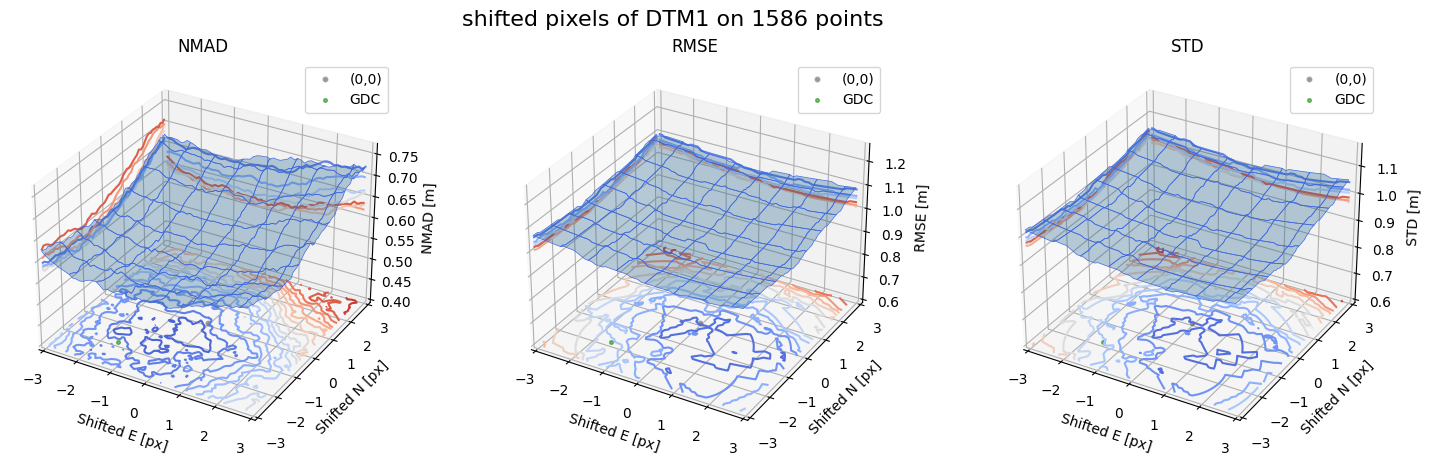

Running best_shift_px on downsampling. The length of the gdf: 1000
Gradient Descending Coreg fit matrix(e_px,n_px,bias),nmad:(-1.7656,0.2284,-0.0659),0.5798
Running on downsampling. The length of the gdf: 1000
Set downsampling = other value or False to make a change.


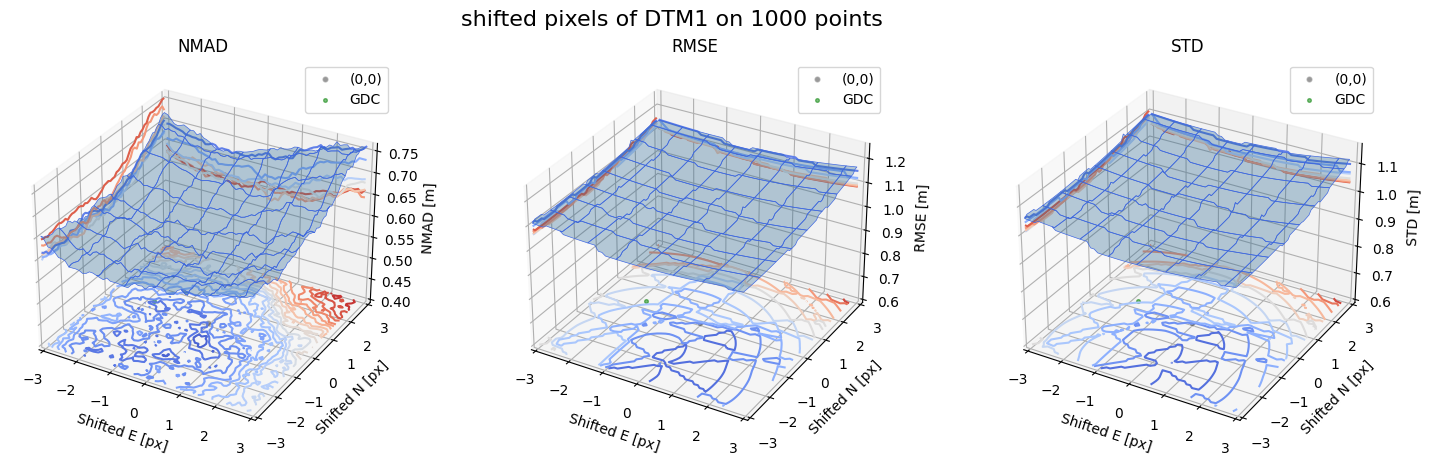

Running best_shift_px on downsampling. The length of the gdf: 500
Gradient Descending Coreg fit matrix(e_px,n_px,bias),nmad:(-1.9736,-2.0781,-0.0555),0.5788
Running on downsampling. The length of the gdf: 500
Set downsampling = other value or False to make a change.


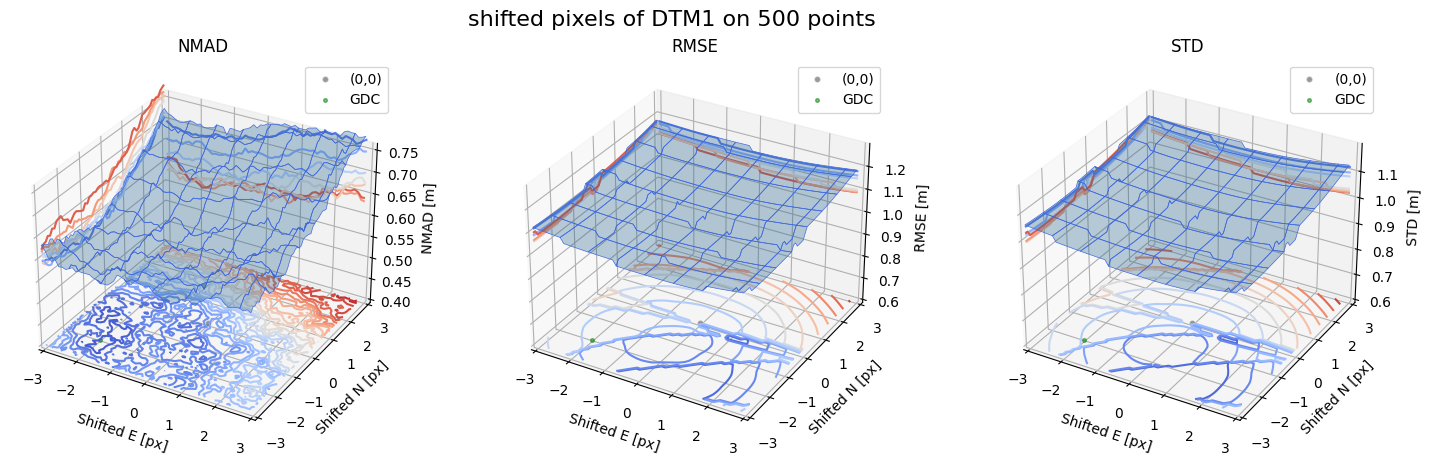

In [48]:
bond = (-3,3,0.1)

# axes limit
xlim=(-3,3)
ylim=(-3,3)

for nmad, rmse, std, median,res,res_nk,res_qc,sampling in yield_surface_noise(dtm_1,sf_subset_dtm1,bond=bond,perc_t=100,std_t=3,downsampling_list=[10000,1000,500],gdc_qc=0,weight='subset_te_flag'):
    z_lim_nmad = (0.4,res[0][3]*2-0.4)
    z_lim_rmse = (0.6,res[0][4]*2-0.8)
    z_lim_std = (0.6,res[0][5]*2-0.8)

    fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18, 5),subplot_kw={"projection": "3d"})
    fig.suptitle(f'shifted pixels of DTM1 on {sampling} points', fontsize=16)
    surface_plot(nmad, bond=bond,xlim=xlim,ylim=ylim,ax=ax1,title='NMAD', res=res,res_1=res_nk, res_2=res_qc, zlabel='NMAD [m]',zlim=z_lim_nmad,z_step_level=0.01)
    surface_plot(rmse,bond=bond,xlim=xlim,ylim=ylim,ax=ax2,title='RMSE',res=res,res_1=res_nk,res_2=res_qc, zlabel='RMSE [m]',zlim=z_lim_rmse,z_step_level=0.01)
    surface_plot(std,bond=bond,xlim=xlim,ylim=ylim,ax=ax3,title='STD',res=res,res_1=res_nk,res_2=res_qc, zlabel='STD [m]',zlim=z_lim_std,z_step_level=0.01)
    plt.show()

## The best fit algorithm and coeficients

Gradient descending can also be implemented by L-BFGS-B from Scipy.optimize if the noise is not severe.

In [49]:
from scipy.optimize import minimize
from xsnow.godh import get_dh_by_shift_px_gdf

# start iteration, find the best shifting px
func_x = lambda x: get_dh_by_shift_px_gdf(dtm_10,sf_subset_dtm10,x,perc_t=100,std_t=3,stat='rmse')
res = minimize(func_x, x0=(0,0), method='L-BFGS-B',bounds=((-3,3),(-3,3)))
res

      fun: 1.5511970187060895
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.        , 0.01073706])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 99
      nit: 7
     njev: 33
   status: 0
  success: True
        x: array([-0.09557894,  0.00446687])

In [50]:
res = minimize(func_x, x0=(0,0), method='BFGS')
res

      fun: 1.5797875171900577
 hess_inv: array([[7.02123e-09, 0.00000e+00],
       [0.00000e+00, 1.00000e+00]])
      jac: array([0.0354276, 0.       ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 237
      nit: 2
     njev: 75
   status: 2
  success: False
        x: array([1.37243807e-07, 0.00000000e+00])

In [51]:
from xsnow.noiseopt import minimizeCompass
res = minimizeCompass(func_x, x0=(0,0), deltainit=2,deltatol=0.006,feps=0.0001,bounds=((-3,3),(-3,3)),errorcontrol=False)
res

    free: array([False, False])
     fun: 1.491898243075958
 message: 'convergence within deltatol'
    nfev: 41
     nit: 14
 success: True
       x: array([-0.359375,  0.25    ])

In [52]:
res = minimizeCompass(func_x, x0=(0,0), deltainit=2,deltatol=0.006,feps=0.0005,bounds=((-3,3),(-3,3)),errorcontrol=False)
res

    free: array([ True, False])
     fun: 1.491898243075958
 message: 'convergence within deltatol. dim 0 is free at optimum'
    nfev: 40
     nit: 13
 success: True
       x: array([-0.359375,  0.25    ])